## Self-Driving Car Engineer Nanodegree
---
### Deep Learning
#### Project: Build a Traffic Sign Recognition Classifier

In [1]:
import requests, io, os
import random
import pickle, zipfile
import collections
import functools

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.contrib.layers import flatten

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.transform import resize
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Prepare env and load files 

data_dir = 'data'
save_dir = 'model'
zip_file = os.path.join(data_dir, 'traffic-signs-data.zip')
zip_url = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'
if not os.path.isfile(zip_file):   
    print("Downloading {}".format(zip_url))
    if not os.path.exists('data'): os.mkdir(data_dir)
    r = requests.get(zip_url, allow_redirects=True)
    open(zip_file, 'wb').write(r.content)

if not os.path.isdir(save_dir): os.mkdir(save_dir)

In [3]:
# Load pickled data

z = zipfile.ZipFile(zip_file)

train_p = pickle.load(z.open('train.p'))
test_p = pickle.load(z.open('test.p'))
    
X_train = train_p['features']
y_train = train_p['labels']
X_test  = test_p['features']
y_test  = test_p['labels']

# Load csv file with sign names
sign_names = pd.read_csv('signnames.csv')


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape 

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Sample sign names from dictionary

In [5]:
sign_names.head()


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Show 1 picture from every class

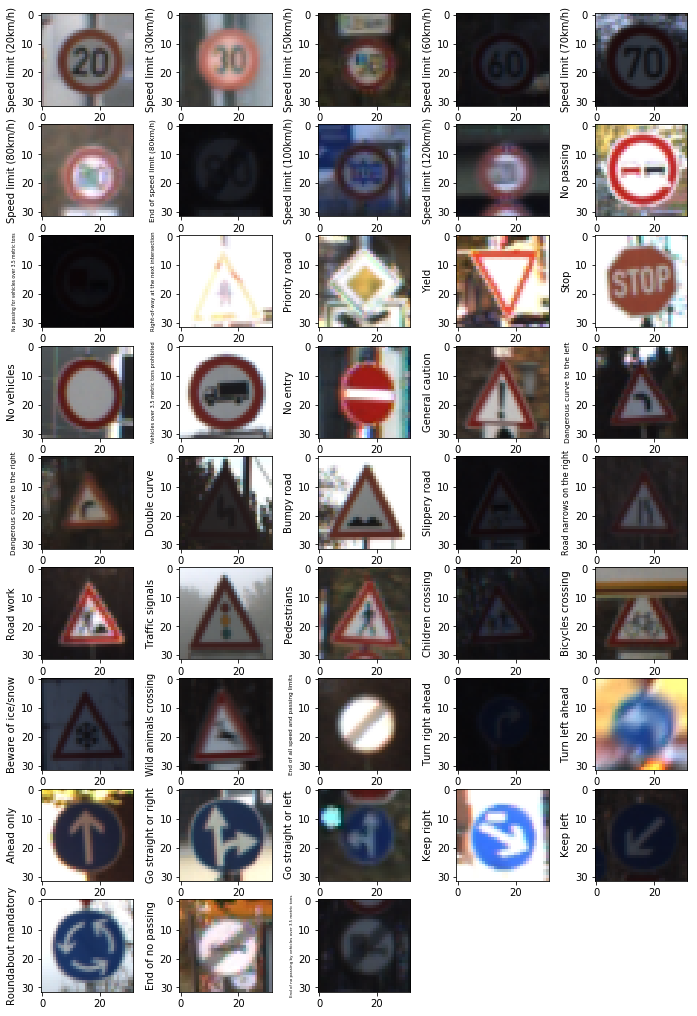

In [6]:

plt.rcParams['figure.figsize'] = (12.0, 18.0)

p_cols = 5
p_rows = (n_classes / p_cols) + 1

# Plot one image for each label
for i in range(0, n_classes):
    sign_name = sign_names.loc[i].SignName
    idx_class = np.where(y_train == i)[0]
    rand_i = np.random.choice(idx_class)
    plt.subplot(p_rows, p_cols, i + 1)
    plt.imshow(X_train[rand_i])
    plt.ylabel(sign_name, fontsize=200/(np.max([20, len(sign_name)])))   
plt.show()

In [7]:
def hist(sign_set):
    plt.figure(figsize=(25,4))
    plt.hist(sign_set, bins=n_classes)
    plt.title("Number of samples per sign type", loc='center')  
    plt.xlabel('Sign')
    plt.ylabel('Count')
    plt.plot()
    

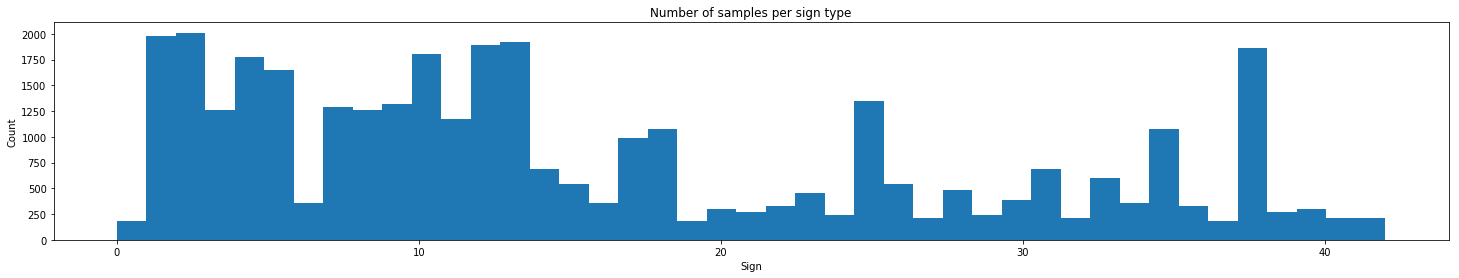

In [8]:
hist(y_train);

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Normalization

In [9]:
# pixel values [0,1]. (images still in color)
def normalize(img):
    img_array = np.asarray(img)
    normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)


Split samples to validation and training sets

In [10]:
X_train_split, X_validate_split, y_train_split, y_validate_split = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=111, 
                                                    stratify=y_train)



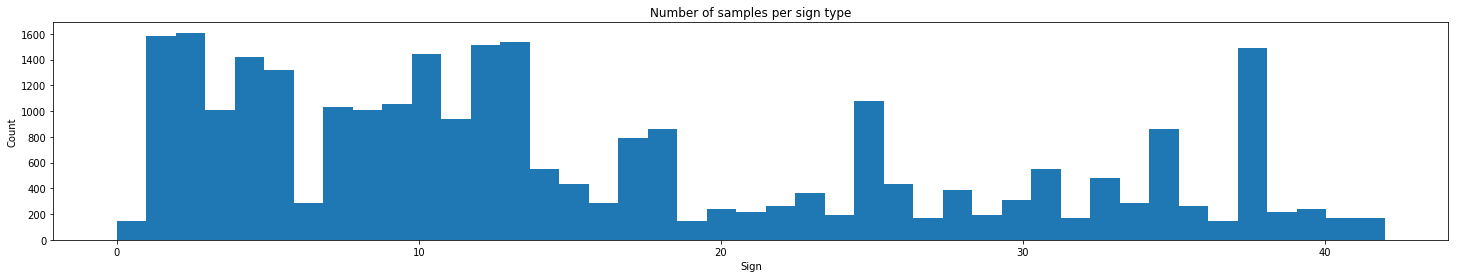

In [11]:
# training split
hist(y_train_split)

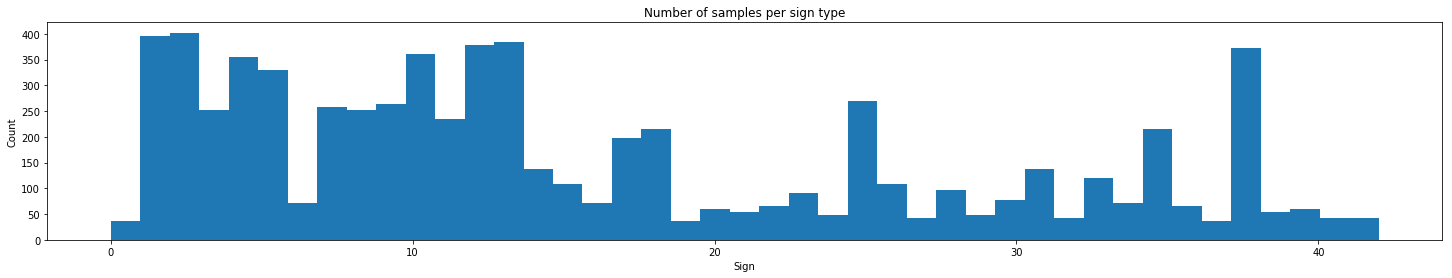

In [12]:
# validation split
hist(y_validate_split)

### Model Architecture

In [13]:
Line = collections.namedtuple('Line', ['w', 'b', 'x'])

X_validate_split, y_validate_split = shuffle(X_validate_split, y_validate_split)

model_save_path = os.path.join(save_dir, 'traffic_classifier')
model_meta_path = os.path.join(save_dir, 'traffic_classifier.meta')

EPOCHS = 160
BATCH_SIZE = 128
LEARNING_RATE = 0.001

CONV_STRIDES = (1, 1, 1, 1)
CONV_PADDING = 'VALID'
POOL_KSIZE   = (1, 2, 2, 1)
POOL_STRIDES = (1, 2, 2, 1)
POOL_PADDING = 'VALID'

# Hyperparameters
MEAN = 0
STDDEV = 0.1

x = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)


In [14]:
# one hot encoding for all possible classes
one_hot_y = tf.one_hot(y, n_classes)

In [15]:
def conv2d(x, shape, mean, stddev):
    size = shape[-1]
    w = tf.Variable(tf.truncated_normal(shape=shape, mean = mean, stddev = stddev))
    b = tf.Variable(tf.zeros(size))
    conv = tf.nn.conv2d(x, w, strides=CONV_STRIDES, padding=CONV_PADDING) + b
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize=POOL_KSIZE, strides=POOL_STRIDES, padding=POOL_PADDING)
    return Line(w=w, b=b, x=conv)

In [16]:
def dropout(x, shape, mean, stddev):
    size = shape[-1]
    w  = tf.Variable(tf.truncated_normal(shape=shape, mean = mean, stddev = stddev))
    b  = tf.Variable(tf.zeros(size))
    fc = tf.matmul(x, w) + b
    fc = tf.nn.relu(fc)
    fc = tf.nn.dropout(fc, keep_prob)
    return  Line(w=w, b=b, x=fc)

In [17]:
def matmul(x, shape, mean, stddev):
    size = shape[-1]
    w  = tf.Variable(tf.truncated_normal(shape=shape, mean = mean, stddev = stddev))
    b  = tf.Variable(tf.zeros(size))
    res = tf.matmul(x, w) + b
    return  Line(w=w, b=b, x=res)

In [18]:
def LeNet(x):    
    mean = MEAN
    stddev = STDDEV
    
    conv1 = conv2d(x, (5, 5, 3, 32), mean, stddev)
    conv2 = conv2d(conv1.x, (5, 5, 32, 64), mean, stddev)
    
    fc0 = flatten(conv2.x)
    fc1 = dropout(fc0, (1600, 1024), mean, stddev)
    fc2 = dropout(fc1.x, (1024,512), mean, stddev)
    
    logits = matmul(fc2.x, (512, 43), mean, stddev)
    weights = [conv1.w, conv2.w, fc1.w, fc2.w, logits.w]   
    
    tf.add_to_collection('logits', logits.x)
    
    return logits.x, weights

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
logits, weights = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)

# L2 Regularization 
regularizers = functools.reduce(lambda s,w : s + tf.nn.l2_loss(w), weights, 0.0)
L2_strength = 1e-6 # L2 values between 1E-2 and 1E-6 have been found to produce good results. (tutorial)
loss_operation = tf.reduce_mean(cross_entropy) + L2_strength * regularizers

optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)


In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def make_batches(x, y):
    x_len = len(x)
    for offset in range(0, x_len, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x = x[offset:end] 
        batch_y = y[offset:end]
        yield batch_x, batch_y  

def training(x_train, y_train):
    sess = tf.get_default_session()
    for batch_x, batch_y in make_batches(x_train, y_train):
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
        
def evaluate(x_data, y_data):
    accuracy = 0
    loss = 0
    examples_size = len(x_data)
    sess = tf.get_default_session()
    for batch_x, batch_y in make_batches(x_data, y_data):
        batch_accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        batch_loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        accuracy += (batch_accuracy * len(batch_x))
        loss += (batch_loss * len(batch_x))
    return accuracy / examples_size, loss / examples_size


In [21]:
# TensorFlow to automatically choose an existing and supported device to run the operations 
# in case the specified one doesn't exist,
config = tf.ConfigProto(allow_soft_placement = True)
# Fraction of the overall amount of memory that each visible GPU should be allocated.
config.gpu_options.per_process_gpu_memory_fraction=0.4

In [22]:
with tf.device('/gpu:0'):
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        print("Training...")
        for i in range(EPOCHS):
            X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
            training(X_train_split, y_train_split)
            training_accuracy, training_loss = evaluate(X_train_split, y_train_split)
            validation_accuracy, validation_loss = evaluate(X_validate_split, y_validate_split)

            if i % 10 == 0:
                print(" EPOCH {} ...".format(i))
                print("  Training Accuracy = {:.5f}".format(training_accuracy))
                print("  Validation Accuracy = {:.5f}".format(validation_accuracy))
                print("  Training Loss = {:.5f}".format(training_loss))
                print("  Validation Loss = {:.5f}".format(validation_loss))

        saver = tf.train.Saver()
        saver.save(sess, model_save_path)
        print("Model saved")

Training...
 EPOCH 0 ...
  Training Accuracy = 0.95679
  Validation Accuracy = 0.95273
  Training Loss = 0.18813
  Validation Loss = 0.19809
 EPOCH 10 ...
  Training Accuracy = 0.99975
  Validation Accuracy = 0.99684
  Training Loss = 0.01066
  Validation Loss = 0.02389
 EPOCH 20 ...
  Training Accuracy = 0.99817
  Validation Accuracy = 0.99397
  Training Loss = 0.01806
  Validation Loss = 0.03665
 EPOCH 30 ...
  Training Accuracy = 0.99925
  Validation Accuracy = 0.99526
  Training Loss = 0.01419
  Validation Loss = 0.03147
 EPOCH 40 ...
  Training Accuracy = 0.99871
  Validation Accuracy = 0.99411
  Training Loss = 0.01782
  Validation Loss = 0.04437
 EPOCH 50 ...
  Training Accuracy = 0.99921
  Validation Accuracy = 0.99454
  Training Loss = 0.01613
  Validation Loss = 0.04074
 EPOCH 60 ...
  Training Accuracy = 0.99975
  Validation Accuracy = 0.99684
  Training Loss = 0.01428
  Validation Loss = 0.04556
 EPOCH 70 ...
  Training Accuracy = 0.99989
  Validation Accuracy = 0.99684
  T

In [23]:
# run model on testing samples
with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        loader = tf.train.import_meta_graph(model_meta_path)
        loader.restore(sess, tf.train.latest_checkpoint(save_dir))
        X_test = normalize(X_test)
        test_accuracy, test_loss = evaluate(X_test, y_test)
        print("Test Accuracy = {:.5f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from model/traffic_classifier
Test Accuracy = 0.95313


---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [24]:
# Load new images sign names
misc_sign_names = pd.read_csv('miscsignnames.csv',index_col=0)
misc_sign_names.head()

,ClassId,SignName
Filename,,
rs_01.jpg,25,Road work
rs_02.jpg,4,Speed limit (70km/h)
rs_03.jpg,33,Turn right ahead
rs_04.jpeg,13,Yield
rs_05.jpg,-1,Pedestrians Only


In [25]:
def load_image(filename): 
    img = mpimg.imread(filename)
    return resize(img, (32, 32), mode='constant', anti_aliasing=True)

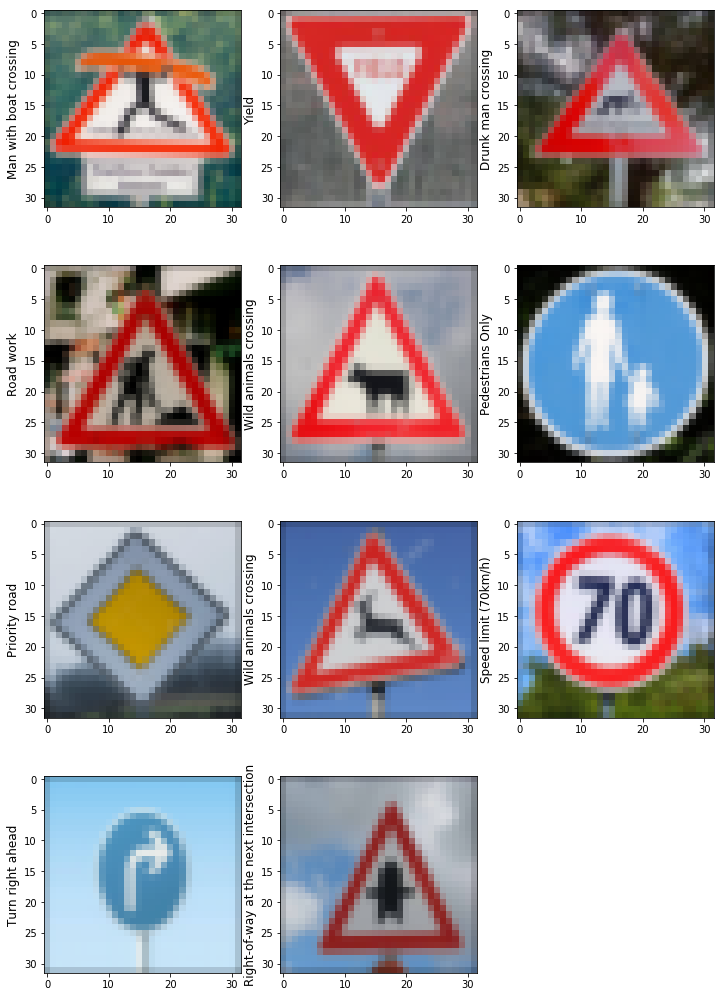

In [26]:
misc_dir = 'misc'

filenames = os.listdir(misc_dir)
misc_len = len(filenames)
misc_cols = 3
misc_rows = (misc_len / misc_cols) + 1

for index, filename in enumerate(filenames):
    sign_name = misc_sign_names.loc[filename].SignName
    img = load_image(os.path.join(misc_dir, filename))
    plt.subplot(misc_rows, misc_cols, index + 1)
    plt.imshow(img)
    plt.ylabel(sign_name, fontsize=12)   
plt.show()    
    


### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from model/traffic_classifier

Sign Name: Man with boat crossing (rs_09.jpg)
 Class_id:4 (Speed limit (70km/h)), confidence:100%
 Class_id:18 (General caution), confidence:0%
 Class_id:26 (Traffic signals), confidence:0%
 Class_id:14 (Stop), confidence:0%
 Class_id:33 (Turn right ahead), confidence:0%


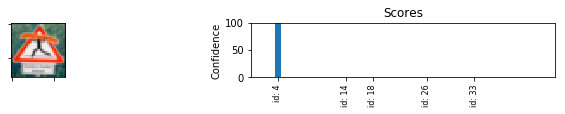


Sign Name: Yield (rs_04.jpeg)
 Class_id:13 (Yield), confidence:100%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:3 (Speed limit (60km/h)), confidence:0%


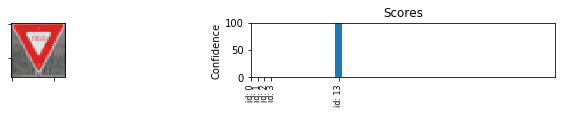


Sign Name: Drunk man crossing (rs_10.jpeg)
 Class_id:10 (No passing for vehicles over 3.5 metric tons), confidence:71%
 Class_id:9 (No passing), confidence:17%
 Class_id:4 (Speed limit (70km/h)), confidence:9%
 Class_id:5 (Speed limit (80km/h)), confidence:2%
 Class_id:22 (Bumpy road), confidence:1%


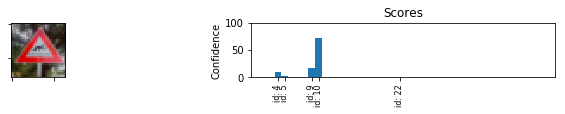


Sign Name: Road work (rs_01.jpg)
 Class_id:25 (Road work), confidence:100%
 Class_id:11 (Right-of-way at the next intersection), confidence:0%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%


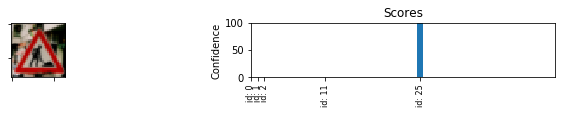


Sign Name: Wild animals crossing (rs_07.jpg)
 Class_id:21 (Double curve), confidence:100%
 Class_id:11 (Right-of-way at the next intersection), confidence:0%
 Class_id:19 (Dangerous curve to the left), confidence:0%
 Class_id:10 (No passing for vehicles over 3.5 metric tons), confidence:0%
 Class_id:31 (Wild animals crossing), confidence:0%


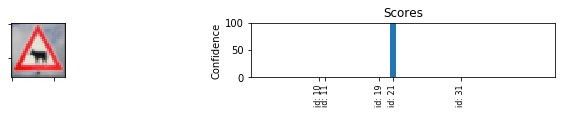


Sign Name: Pedestrians Only (rs_05.jpg)
 Class_id:34 (Turn left ahead), confidence:100%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:3 (Speed limit (60km/h)), confidence:0%


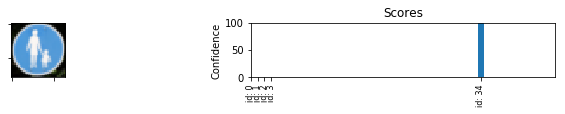


Sign Name: Priority road (rs_08.jpg)
 Class_id:12 (Priority road), confidence:100%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:3 (Speed limit (60km/h)), confidence:0%


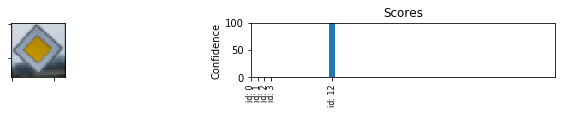


Sign Name: Wild animals crossing (rs_11.jpg)
 Class_id:31 (Wild animals crossing), confidence:100%
 Class_id:10 (No passing for vehicles over 3.5 metric tons), confidence:0%
 Class_id:25 (Road work), confidence:0%
 Class_id:19 (Dangerous curve to the left), confidence:0%
 Class_id:11 (Right-of-way at the next intersection), confidence:0%


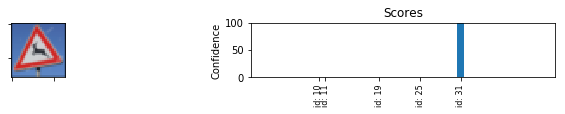


Sign Name: Speed limit (70km/h) (rs_02.jpg)
 Class_id:4 (Speed limit (70km/h)), confidence:100%
 Class_id:33 (Turn right ahead), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:19 (Dangerous curve to the left), confidence:0%
 Class_id:35 (Ahead only), confidence:0%


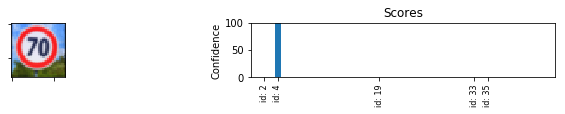


Sign Name: Turn right ahead (rs_03.jpg)
 Class_id:33 (Turn right ahead), confidence:100%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:3 (Speed limit (60km/h)), confidence:0%


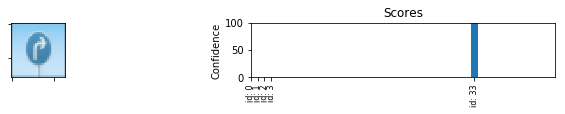


Sign Name: Right-of-way at the next intersection (rs_06.jpg)
 Class_id:11 (Right-of-way at the next intersection), confidence:100%
 Class_id:0 (Speed limit (20km/h)), confidence:0%
 Class_id:1 (Speed limit (30km/h)), confidence:0%
 Class_id:2 (Speed limit (50km/h)), confidence:0%
 Class_id:3 (Speed limit (60km/h)), confidence:0%


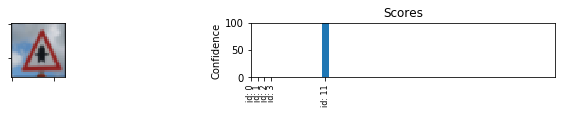

In [27]:
def misc_image_graph(img, filename, classes, predict_confidence):
    
    fig = plt.figure(figsize=(12, 1))

    sub_img = fig.add_subplot(1, 2, 1)
    sub_img.imshow(img)
    sub_img.set_yticklabels([])
    sub_img.set_xticklabels([])

    bar_img = fig.add_subplot(1, 2, 2)
    width = 1      
    rect = bar_img.bar(classes, predict_confidence*100, width)
    bar_img.set_xlim(0, n_classes + 2)
    bar_img.set_ylim(0, 100)
    bar_img.set_ylabel('Confidence')
    bar_img.set_title('Scores')
    x_tick_marks = list(map(lambda c: 'id: {}'.format(classes[c]), range(0, len(classes))))
    bar_img.set_xticks(classes)
    x_tick_names = bar_img.set_xticklabels(x_tick_marks)
    plt.setp(x_tick_names, rotation=90, fontsize=8)
    plt.show()
    plt.close

filenames = os.listdir(misc_dir)

with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        loader = tf.train.import_meta_graph(model_meta_path)
        loader.restore(sess, tf.train.latest_checkpoint(save_dir))
        logits = tf.get_collection('logits')[0]

        print()
        top_k = 5
        for filename in filenames:
            img = load_image(os.path.join(misc_dir, filename))
            norm_img = normalize(img)
            test_prediction = tf.nn.softmax(logits)
            classification = sess.run(test_prediction, feed_dict = {x: [norm_img], keep_prob: 1.0})
            test_class = sess.run(tf.argmax(classification, 1))
            value, indices = sess.run(tf.nn.top_k(tf.constant(classification), k=top_k))

            predict_confidence = value.squeeze()
            indices = indices.squeeze()
            sign_name = misc_sign_names.loc[filename].SignName
            print('Sign Name: {} ({})'.format(sign_name, filename))
            
            for cl_id, confid in zip(indices, predict_confidence):
                cl_name = sign_names.loc[cl_id].SignName
                print(' Class_id:{0} ({1}), confidence:{2:.0%}'.format(cl_id, cl_name, confid))
                
            misc_image_graph(img, filename, indices, predict_confidence)
            print()    
                


### Analyze Performance

# Calculate the accuracy for these new images. 
#### Image 1
 filename: rs_01.jpg (Road work) was identified correctly with confidence 100%
#### Image 2
 filename: rs_02.jpg (Speed limit (70km/h)) was identified correctly with confidence 100%
#### Image 3
 filename: rs_03.jpg (Turn right ahead) was identified correctly with confidence 100%
#### Image 4
 filename: rs_04.jpeg (Yield) was identified correctly with confidence 100%
#### Image 5
 filename: rs_05.jpg (Pedestrians Only) was identified incorrectly with confidence 100% (sign was not in training set)
#### Image 6
 filename: rs_06.jpg (Right-of-way at the next intersection) was identified correctly with confidence 100%
#### Image 7
 filename: rs_07.jpg (Wild animals crossing) was identified incorrectly with confidence 100% (sign was not in training set)
#### Image 8
 filename: rs_08.jpg (Priority road) was identified correctly with confidence 100%
#### Image 9
 filename: rs_09.jpg (Man with boat crossing) was identified incorrectly with confidence 100% (sign was not in training set)
#### Image 10
 filename: rs_10.jpeg (Drunk man crossing) was identified incorrectly with confidence 71% (sign was not in training set)
#### Image 11
 filename: rs_11.jpg (Wild animals crossing) was identified correctly with confidence 100%